In [3]:
import numpy as np
import pandas as pd
import os

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist.data, mnist.target
y = y.astype(np.uint8)
print(X.shape, y.shape)

(70000, 784) (70000,)


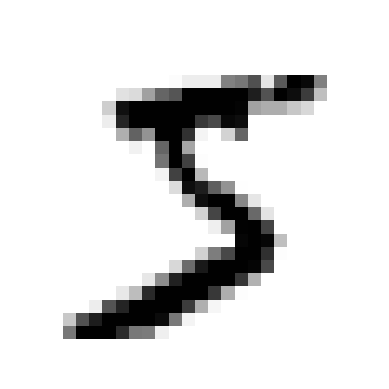

5


In [6]:
import matplotlib.pyplot as plt

some_digit = np.array(X.loc[0])
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print(y[0])

In [7]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit, X.loc[1]])

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True, False])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42,shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5.loc[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5.loc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator

class NeverSClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = NeverSClassifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [16]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold  = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [19]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

(60000,) (60000,)


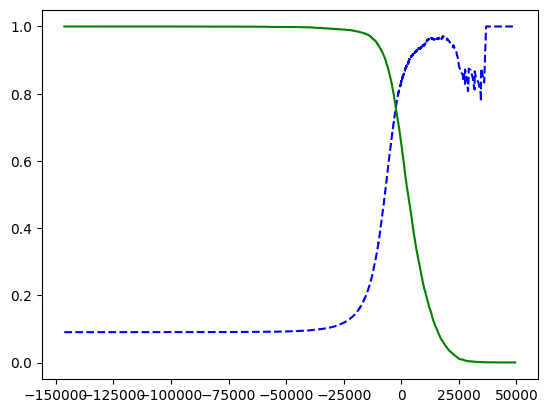

In [21]:
from sklearn.metrics import precision_recall_curve
print(y_train_5.shape, y_scores.shape)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


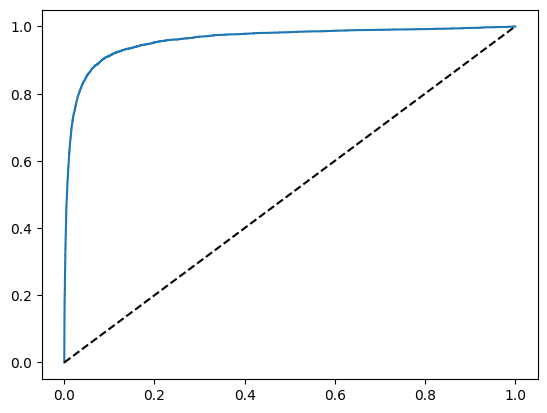

In [23]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], "k--")

plot_roc_curve(fpr, tpr)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

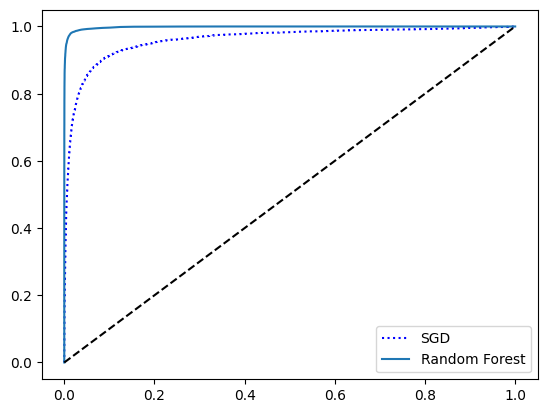

In [26]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [28]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [29]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]
5


C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [30]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.w

In [31]:
print(sgd_clf.decision_function([some_digit]))
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

[2164.22030239]


C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


[0.87365 0.85835 0.8689 ]


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


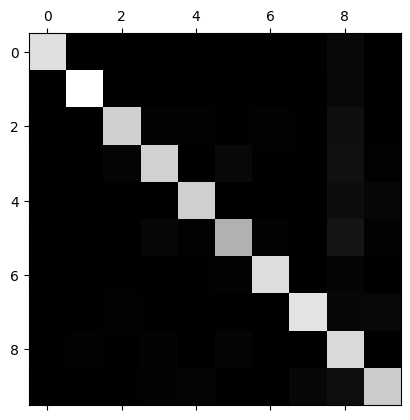

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

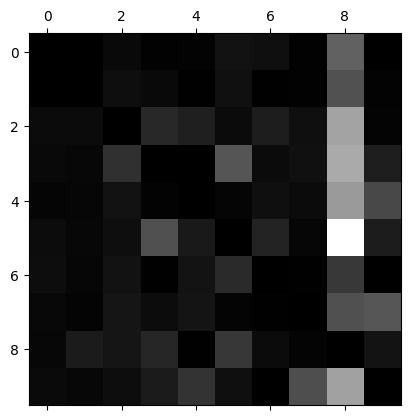

In [34]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [35]:
import matplotlib.cm as pltcm

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = pltcm.binary, **options)
    plt.axis("off")

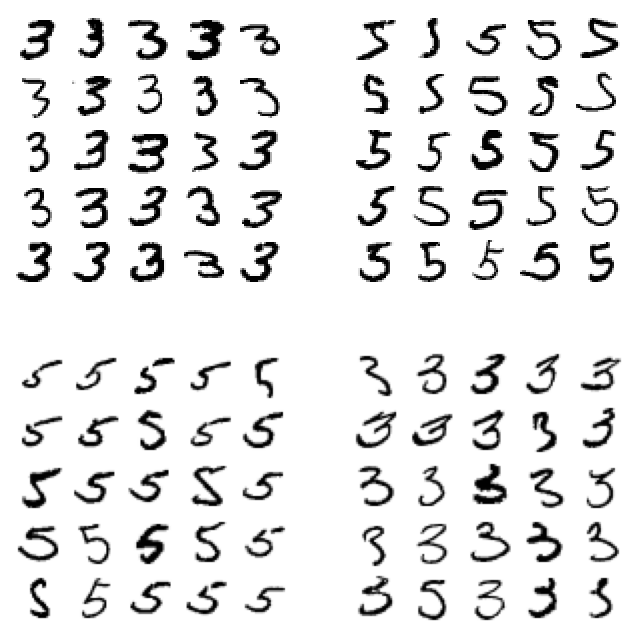

In [102]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(np.array(X_aa[:25]), images_per_row=5)
plt.subplot(222); plot_digits(np.array(X_ba[:25]), images_per_row=5)
plt.subplot(223); plot_digits(np.array(X_bb[:25]), images_per_row=5)
plt.subplot(224); plot_digits(np.array(X_ab[:25]), images_per_row=5)
plt.show()

In [59]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [61]:
print(knn_clf.predict([some_digit]))
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="macro"))

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


[[False  True]]
0.9764102655606048


In [62]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [76]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = pltcm.binary,
               interpolation="nearest")
    plt.axis("off")

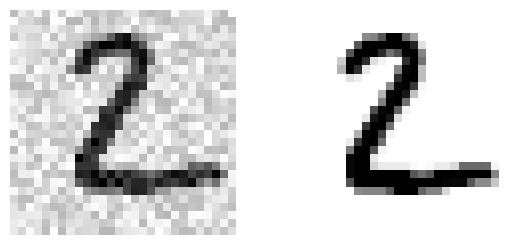

In [100]:
some_index = 60001
plt.subplot(121); plot_digit(np.array([X_test_mod.loc[some_index]]))
plt.subplot(122); plot_digit(np.array([y_test_mod.loc[some_index]]))
plt.show()

C:\Users\nilot\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


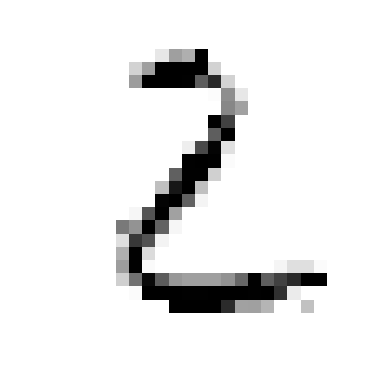

In [101]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(np.array([X_test_mod.loc[some_index]]))
plot_digits(clean_digit)
plt.show()